- Exact match queries (get morphologies from a brain region X)
- Multiple embedding vectors produced by models tackling similarity according to different aspects (vectors representing a morphology in a latent co-projection graph space, get 10 most similar morphologies in that space)
- Ontology queries (get similar species, similar or adjacent brain region: get morphologies of this species/brain region)
- Full text search

- Rule-based approach
- Vector similarity-based approach


For embeddings, we need to build rank aggregation functions:
https://arxiv.org/pdf/1906.06011.pdf

"Rank aggregation functions allow retrieval models (or rankers) to be builton top of others.  They combine results from different rankers and promote moreeffective retrieval results, without dealing with raw data or low-level descriptors. Besides, even heterogeneous models such as text-based or image-based can begathered together.  Rank aggregation techniques are important in many appli-cations, such as meta-search, document filtering, recommendation systems, andsocial choice."

In [40]:
import ast
import math
import pickle
import re
import getpass
import requests
import faiss

from collections import defaultdict

import networkx as nx
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from bluegraph import PandasPGFrame
from bluegraph.backends.networkx import networkx_to_pgframe, NXPathFinder
from bluegraph.downstream import transform_to_2d, plot_2d

from kgforge.core import KnowledgeGraphForge

from elasticsearch import Elasticsearch, helpers

#  Prepare a sample data

In [2]:
data = pd.read_csv("combined_data.csv")

In [3]:
data.head(4)

,@id,coordinates,neurite_features,axon_coproj_embedding,dendrite_coproj_embedding,brain_region,atlas_release,object_of_study,protocol_id
0,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[7201.0, 3716.0, 3749.0]","[0.0, 0.0, -0.07088812050083358, -0.1050534381...","[0.1190783753991127, -0.09802958369255066, -0....","[-0.20872348546981812, 0.22727429866790771, -0...",VPM,https://bbp.epfl.ch/neurosciencegraph/data/831...,Single Cell,https://bbp.epfl.ch/neurosciencegraph/data/781...
1,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[7075.0, 3636.0, 3527.0]","[0.0, 0.0, -0.07088812050083358, -1.0812090297...","[0.12326409667730331, -0.18537746369838715, -0...","[-0.20932914316654205, 0.23228919506072998, -0...",VPM,https://bbp.epfl.ch/neurosciencegraph/data/831...,Single Cell,https://bbp.epfl.ch/neurosciencegraph/data/781...
2,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[7198.0, 3515.0, 3370.0]","[0.0, 0.0, -0.07088812050083358, -0.8884510254...","[0.15842680633068085, -0.14361251890659332, -0...","[-0.13695301115512848, 0.21037553250789642, -0...",VPM,https://bbp.epfl.ch/neurosciencegraph/data/831...,Single Cell,https://bbp.epfl.ch/neurosciencegraph/data/781...
3,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[7297.0, 3313.0, 3460.0]","[0.0, 0.0, -0.07088812050083358, -0.7066540810...","[0.11594384163618088, -0.1404164433479309, -0....","[-0.19318708777427673, 0.10199242830276489, -0...",VPM,https://bbp.epfl.ch/neurosciencegraph/data/831...,Single Cell,https://bbp.epfl.ch/neurosciencegraph/data/781...


In [4]:
KEYWORDS = [
    "@id", "@type",
    "brain_region",
    "atlas_release",
    "object_of_study",
]

In [5]:
EMBEDDING_VECTORS = [
    "coordinates", "neurite_features",
    "axon_coproj_embedding", "dendrite_coproj_embedding"
]

In [6]:
for c in EMBEDDING_VECTORS:
    data[c] = data[c].apply(lambda x: ast.literal_eval(x))

Scale coordinates

In [7]:
coordinates = np.array(data["coordinates"].tolist())

In [8]:
data["coordinates"] = (coordinates / coordinates.max()).tolist()

In [9]:
releases = ["release1", "release2", "release3"]
data["atlas_release"] = pd.Series([
    np.random.choice(releases, p=[0.4, 0.4, 0.2])
    for n in data["@id"]
])
objects = ["Single Cell", "Whole Brain"]
data["object_of_study"] = pd.Series([
    np.random.choice(objects, p=[0.6, 0.4])
    for n in data["@id"]
])

In [10]:
morphologies = data[["@id", "brain_region", "atlas_release", "object_of_study"]]
morphologies["@type"] = "NeuronMorphology"

/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
brain_region_frame = PandasPGFrame.load_json("brain_region_data.json")

In [12]:
finder = NXPathFinder(brain_region_frame, directed=False)

In [13]:
def brain_region_ontology_distance(finder, r1, r2):
    return math.ceil(math.log2(len(finder.shortest_path(r1, r2))))

In [169]:
brain_region_ontology_distance(finder, "VPL", "MG")

3

In [174]:
math.log2(len(finder.shortest_path("VPL", "MG")))

2.584962500721156

In [178]:
finder.shortest_path("VPL", "MG")

('VPL', 'VP', 'VENT', 'DORsm', 'GENd', 'MG')

In [177]:
int(finder.shortest_path("VPL", "LP")

('VPL', 'VP', 'VENT', 'DORsm', 'TH', 'DORpm', 'LAT', 'LP')

In [185]:
int(math.log2(len(finder.shortest_path("VPL", "VPM"))))

1

In [186]:
int(math.log2(len(finder.shortest_path("VPL", "MG"))))

2

In [187]:
int(math.log2(len(finder.shortest_path("VPL", "LP"))))

3

# Experiments with rank aggregation

## Create Faiss indices

In [14]:
def create_index(dim, vectors, similarity="cosine"):
    vectors = np.array(vectors).astype(np.float32)
    if similarity == "cosine":
        index = faiss.IndexFlatIP(dim)
        faiss.normalize_L2(vectors)
    else:
        index = faiss.IndexFlatL2(dim)
    index.add(vectors)
    return index

In [15]:
def query_index(index, point_ids, k, similarity="euclidean"):
    vectors = np.array([
        index.reconstruct(point)
        for point in point_ids
    ])
    if similarity == "cosine":
        faiss.normalize_L2(vectors)
    return index.search(vectors, k)

In [16]:
coordiates_index = create_index(3, data["coordinates"].tolist(), similarity="euclidean")

In [17]:
neurite_feature_index = create_index(
    len(data["neurite_features"].iloc[0]), data["neurite_features"].tolist(), similarity="euclidean")

In [18]:
axon_index = create_index(
    len(data["axon_coproj_embedding"].iloc[0]), data["axon_coproj_embedding"].tolist(), similarity="euclidean")

In [19]:
dendrite_index = create_index(
    len(data["dendrite_coproj_embedding"].iloc[0]), data["dendrite_coproj_embedding"].tolist(), similarity="euclidean")

In [20]:
# SIMILARITIES = {
#     "coordindates": "euclidean",
#     "neurite_features": "euclidean",
#     "axon_coproj": "cosine",
#     "dendrite_coproj": "cosine"
# }
# INDICES = {
#     "coordindates": coordiates_index,
#     "neurite_features": neurite_feature_index,
#     "axon_coproj": axon_index,
#     "dendrite_coproj": dendrite_index
# }

In [154]:
SIMILARITIES = {
    "coordindates": "euclidean",
    "neurite_features": "euclidean",
    "axon_coproj": "euclidean",
    "dendrite_coproj": "euclidean"
}
INDICES = {
    "coordindates": coordiates_index,
    "neurite_features": neurite_feature_index,
    "axon_coproj": axon_index,
    "dendrite_coproj": dendrite_index
}
COLORS = {
    "axon_coproj": "red",
    "dendrite_coproj": "blue",
    "neurite_features": "orange",
    "coordindates": "green"
}

In [22]:
BENCHMARK_POINTS = [
    int(p)
    for p in np.random.choice(range(data.shape[0]), 50)
]
K = 20

In [23]:
individual_benchmarks = {}
for index_name, index in INDICES.items():
    _, points = query_index(index, BENCHMARK_POINTS, K)
    individual_benchmarks[index_name] = {
        BENCHMARK_POINTS[i]: pset
        for i, pset in enumerate(points)
    }

## Vecotor concatenation + PCA (Offline: building index)

In [24]:
all_features = np.hstack([
    np.vstack(data["coordinates"].values),
    np.vstack(data["neurite_features"].values),
    np.vstack(data["axon_coproj_embedding"].values),
    np.vstack(data["dendrite_coproj_embedding"].values)])
print(all_features.shape[1])

274


In [25]:
pca = sk.decomposition.PCA(n_components=128)
reduced_features = pca.fit_transform(all_features)
print(sum(pca.explained_variance_ratio_))
concatenated_index = create_index(
    reduced_features.shape[1], np.ascontiguousarray(reduced_features, dtype=np.float32))

0.9981933955026131


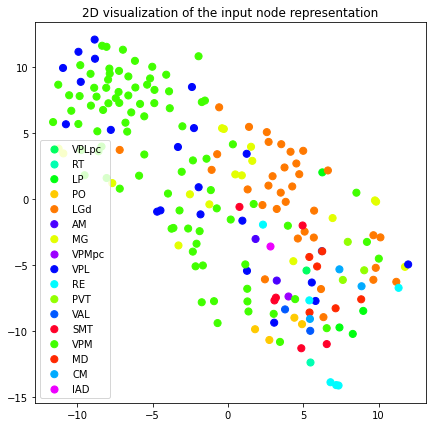

In [26]:
embedding_2d = transform_to_2d(all_features.tolist())
plot_2d(None, vectors=embedding_2d, labels=data["brain_region"])

In [27]:
_, points = query_index(concatenated_index, BENCHMARK_POINTS, K)

In [28]:
concatenated_benchmarks = {
    BENCHMARK_POINTS[i]: pset for i, pset in enumerate(points)
}

In [29]:
all_features_no_coord = np.hstack([
    np.vstack(data["neurite_features"].values),
    np.vstack(data["axon_coproj_embedding"].values),
    np.vstack(data["dendrite_coproj_embedding"].values)])
print(all_features_no_coord.shape[1])

271


In [30]:
pca = sk.decomposition.PCA(n_components=128)
reduced_features = pca.fit_transform(all_features_no_coord)
print(sum(pca.explained_variance_ratio_))
concatenated_index = create_index(
    reduced_features.shape[1], np.ascontiguousarray(reduced_features, dtype=np.float32))

0.9982358506246897


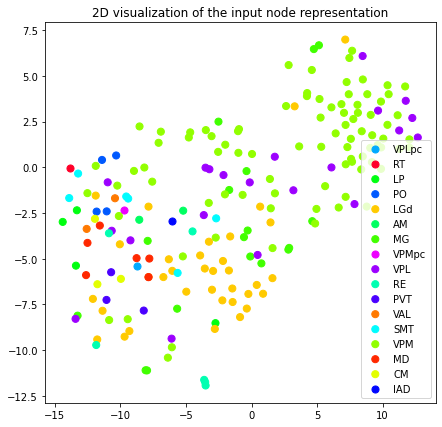

In [33]:
embedding_2d = transform_to_2d(all_features_no_coord.tolist())
plot_2d(None, vectors=embedding_2d, labels=data["brain_region"])

In [34]:
_, points = query_index(concatenated_index, BENCHMARK_POINTS, K)

In [35]:
concatenated_minus_benchmarks = {
    BENCHMARK_POINTS[i]: pset for i, pset in enumerate(points)
}

__Issues__:

- Some embeddings can have features with high variance, dominating over the other embeddings
- Combining things for which different similarity metrics should be employed does not make much sense

## Naive score aggregation

### Average aggregation

In [36]:
def get_average_score(indices, query, k,
                      distance_normalizer=None,
                      similarity_normalizer=None, distance=False):
    if distance_normalizer is None:
        distance_normalizer = lambda x, index_name: x
    
    if similarity_normalizer is None:
        similarity_normalizer = lambda x, index_name: x

    all_points = set()
    computed_scores = {}
    for index_name, index in indices.items():
        scores, points = query_index(index, [query], k)
        computed_scores[index_name] = {
            p: scores[0][i] for i, p in enumerate(points[0])
        }
        all_points.update(points[0])

    global_score = {p: [] for p in all_points}
    for index_name, index in indices.items():
        dist = index.get_distance_computer()
        for p in all_points:
            p_score = (
                computed_scores[index_name][p]
                if p in computed_scores[index_name]
                else dist.symmetric_dis(query, int(p))
            )
            if distance:
                p_score = distance_normalizer(p_score, index_name)
                p_score = 1 / (1 + p_score)
            global_score[p].append(similarity_normalizer(p_score, index_name))
    return pd.DataFrame([
        [point, sum(score) / len(indices)]
        for point, score in global_score.items()
    ]).nlargest(k, columns=1)[0].tolist()

In [37]:
get_average_score(INDICES, 0, K, distance=True)

[0,
 153,
 151,
 104,
 174,
 91,
 83,
 61,
 188,
 189,
 45,
 179,
 99,
 117,
 167,
 46,
 12,
 2,
 9,
 29]

__Issues__:

    - similarity scores have different distributions, hard to compare)

### Experiment with distance distributions

In [157]:
points = list(range(data.shape[0]))
similarities = defaultdict(list)
for index_name, index in INDICES.items():
    comp = index.get_distance_computer()
    for p1 in points:
        for p2 in points:
            if p1 < p2:
                d = comp.symmetric_dis(p1, p2)
                similarities[index_name].append(d)

coordindates
	range: [0.00, 0.19]
	mean: 0.03, std: 0.03


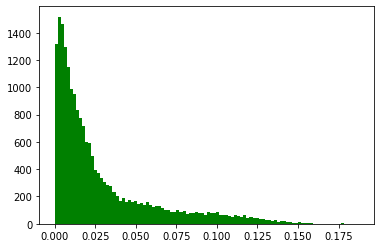

neurite_features
	range: [0.00, 268.84]
	mean: 18.09, std: 24.55


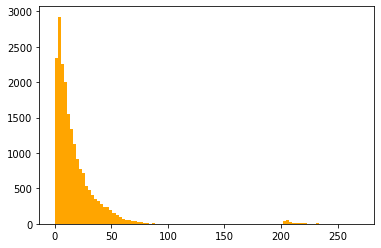

axon_coproj
	range: [0.15, 3.84]
	mean: 0.49, std: 0.37


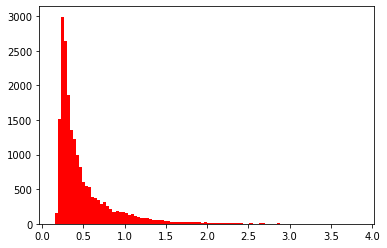

dendrite_coproj
	range: [0.13, 3.49]
	mean: 0.61, std: 0.54


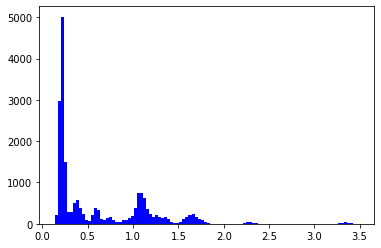

In [161]:
for k in similarities:
    values = np.array(similarities[k])
    print(k)
    print("\trange: [{:.2f}, {:.2f}]".format(min(values), max(values)))
    print("\tmean: {:.2f}, std: {:.2f}".format(values.mean(), values.std()))
    plt.hist(values, bins=100, color=COLORS[k])
    plt.show()

In [48]:
MEANS = {
    k: np.array(similarities[k]).mean() for k in similarities
}

In [49]:
SCALERS = {}

	range: [0.00, 6.55]
	mean: 1.00, std: 1.11


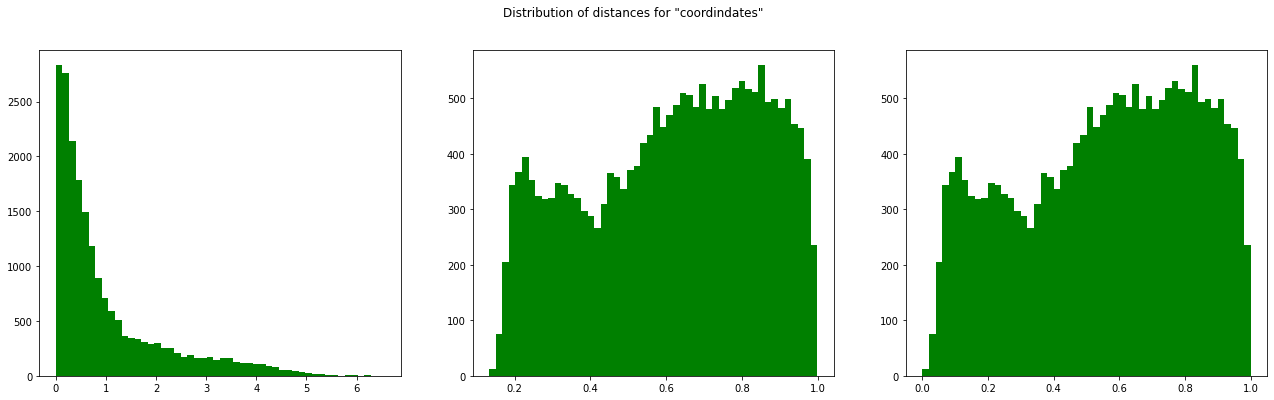

	range: [0.00, 14.86]
	mean: 1.00, std: 1.36


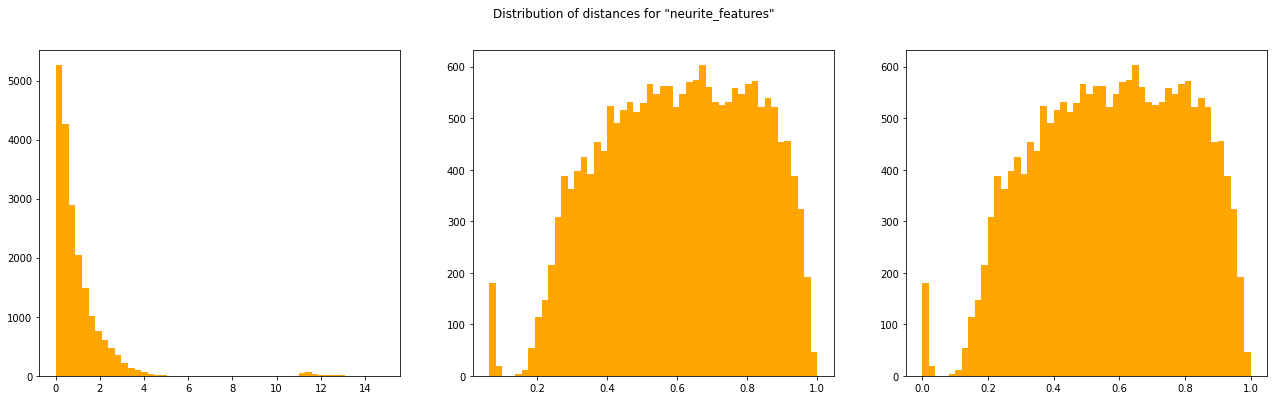

	range: [0.30, 7.77]
	mean: 1.00, std: 0.76


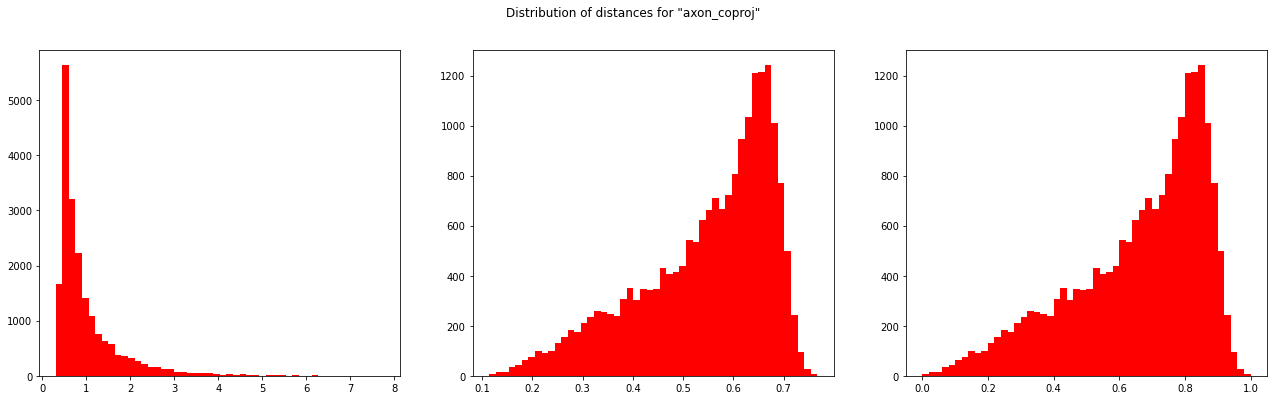

	range: [0.22, 5.74]
	mean: 1.00, std: 0.89


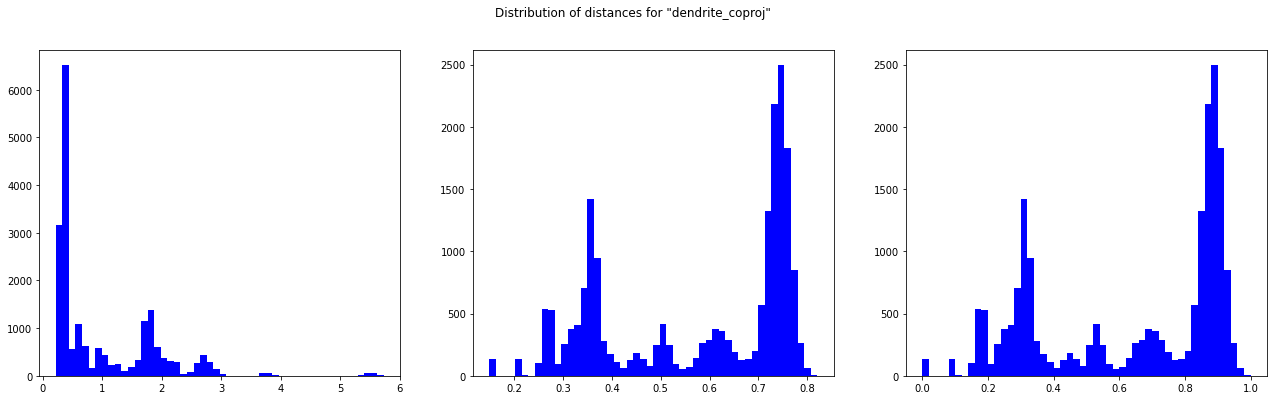

In [188]:
for k in similarities:
    raw_values = np.array(similarities[k])
    if SIMILARITIES[k] == "euclidean":
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))
        fig.suptitle(f'Distribution of distances for "{k}"')
        raw_scaled_values = raw_values / raw_values.mean()
        print("\trange: [{:.2f}, {:.2f}]".format(min(raw_scaled_values), max(raw_scaled_values)))
        print("\tmean: {:.2f}, std: {:.2f}".format(raw_scaled_values.mean(), raw_scaled_values.std()))
        sim_values = 1 / (1 + raw_scaled_values)
        scaler = sk.preprocessing.MinMaxScaler()
        scaled_values = scaler.fit_transform(np.reshape(sim_values, (-1, 1)))
        SCALERS[k] = scaler
        ax1.hist(raw_scaled_values, bins=50, color=COLORS[k])
        ax2.hist(sim_values, bins=50, color=COLORS[k])
        ax3.hist(scaled_values, bins=50, color=COLORS[k])
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
        fig.suptitle(f'Distribution of distances for "{k}"')
        scaler = sk.preprocessing.MinMaxScaler()
        scaled_values = scaler.fit_transform(np.reshape(raw_values, (-1, 1)))
        SCALERS[k] = scaler
        ax1.hist(raw_values, bins=50, color=COLORS[k])
        ax2.hist(scaled_values, bins=50, color=COLORS[k])
        print(min(scaled_values), max(scaled_values))
    plt.show()
        

Further 'equalization' of idividual similarity distributions can be done if we have some training set:

User considers that any two images in a given repository are similar given their similarity value $x_i$ (the subindex refers to using the ith basic similarity measure).

- $p(similar|x)$ the posterior probability
- $p(similar)$ the prior probability of images being similar 
- $p(x|similar)$ the conditional probability density function associated with similarity values

See https://www.sciencedirect.com/science/article/pii/S0167865508002511


Other fusion functions are discussed here:
https://pubs.acs.org/doi/pdf/10.1021/ci300547g

In [52]:
avg_benchmarks = {
    p: get_average_score(
        INDICES, p, K, distance=True,
        distance_normalizer=lambda x, index_name: x / MEANS[index_name],
        similarity_normalizer=lambda x, index_name: SCALERS[index_name].transform(np.atleast_2d(x))[0][0])
    for p in BENCHMARK_POINTS
}

Get details on each match

In [117]:
def scale_by_mean(x, index_name):
    return x / MEANS[index_name]

def min_max_scale(x, index_name):
    return SCALERS[index_name].transform(np.atleast_2d(x))[0][0]

In [150]:
query = 0
result = get_average_score(
    INDICES, query, 30, distance=True,
    distance_normalizer=scale_by_mean,
    similarity_normalizer=min_max_scale)

Morphology 0
	 coordindates : 1/50
	 neurite_features : 1/50
	 axon_coproj : 1/50
	 dendrite_coproj : 1/50


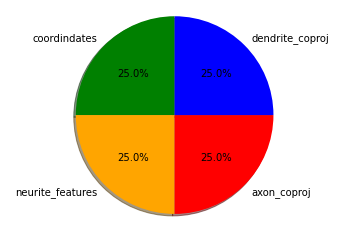

Morphology 189
	 coordindates : 16/50
	 neurite_features : 36/50
	 axon_coproj : 11/50
	 dendrite_coproj : 3/50


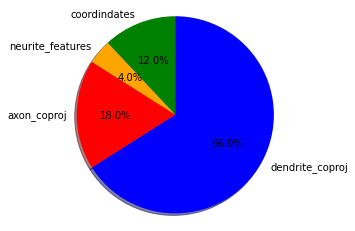

Morphology 153
	 neurite_features : 4/50
	 axon_coproj : 2/50
	 dendrite_coproj : 29/50


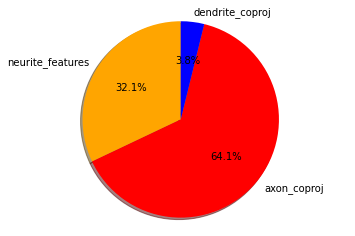

Morphology 12
	 coordindates : 4/50
	 axon_coproj : 32/50
	 dendrite_coproj : 11/50


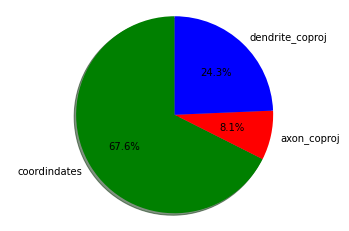

Morphology 174
	 neurite_features : 18/50
	 axon_coproj : 4/50
	 dendrite_coproj : 24/50


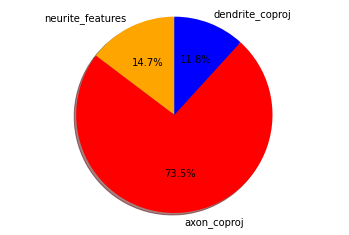

Morphology 179
	 coordindates : 29/50
	 neurite_features : 34/50
	 axon_coproj : 16/50


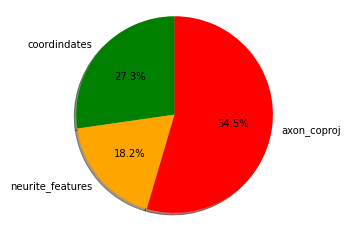

Morphology 188
	 coordindates : 35/50
	 neurite_features : 19/50
	 dendrite_coproj : 28/50


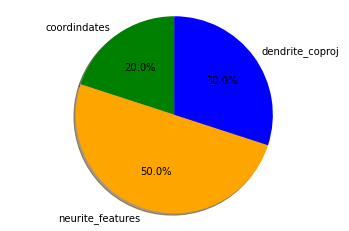

Morphology 184
	 coordindates : 27/50
	 axon_coproj : 10/50


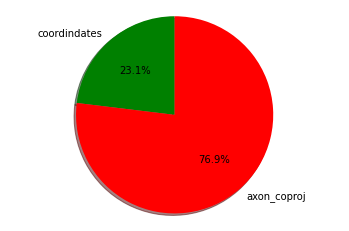

Morphology 46
	 coordindates : 48/50
	 axon_coproj : 3/50


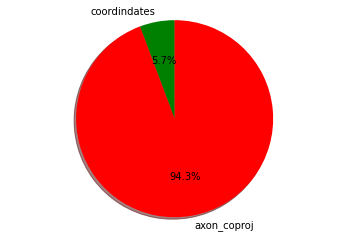

Morphology 2
	 coordindates : 42/50
	 axon_coproj : 7/50


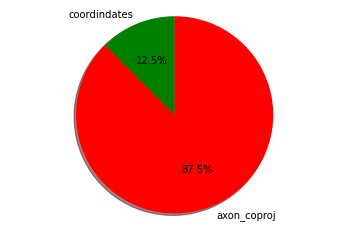

Morphology 1
	 coordindates : 12/50
	 dendrite_coproj : 48/50


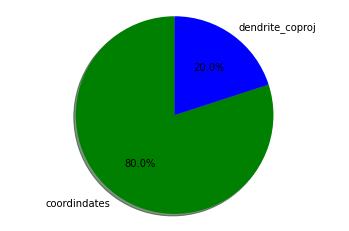

Morphology 167
	 neurite_features : 50/50
	 axon_coproj : 5/50


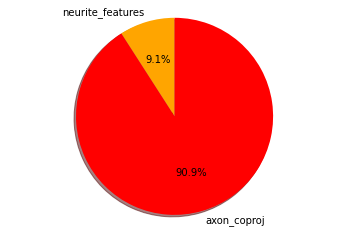

Morphology 186
	 coordindates : 22/50
	 neurite_features : 42/50


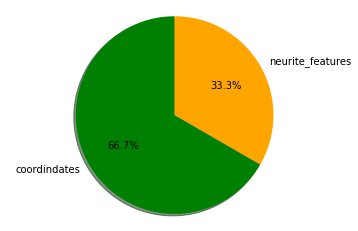

Morphology 185
	 coordindates : 9/50
	 axon_coproj : 8/50


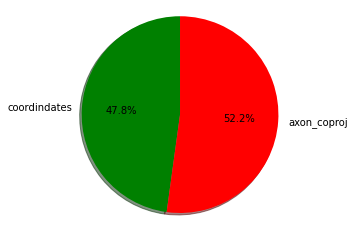

Morphology 187
	 coordindates : 28/50
	 axon_coproj : 45/50


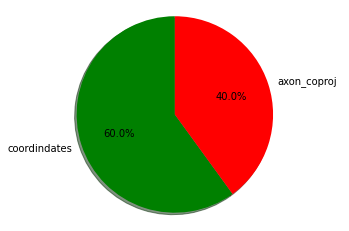

Morphology 151
	 neurite_features : 9/50
	 axon_coproj : 29/50
	 dendrite_coproj : 42/50


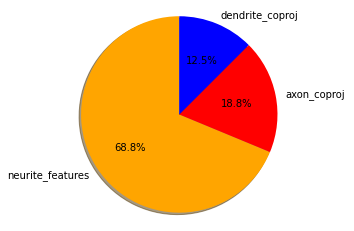

Morphology 9
	 axon_coproj : 12/50


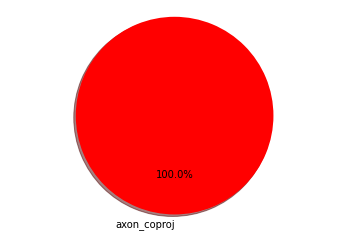

Morphology 182
	 coordindates : 14/50
	 axon_coproj : 31/50


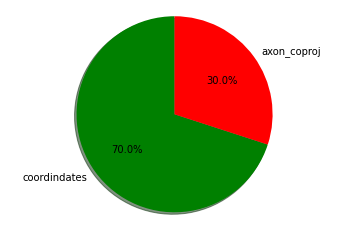

Morphology 190
	 coordindates : 6/50
	 dendrite_coproj : 27/50


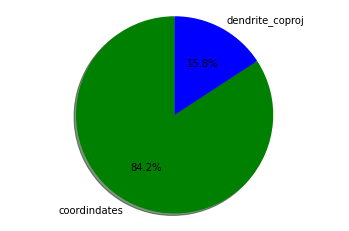

Morphology 150
	 coordindates : 46/50
	 axon_coproj : 19/50


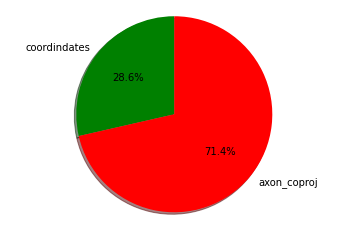

Morphology 11
	 coordindates : 5/50
	 axon_coproj : 25/50


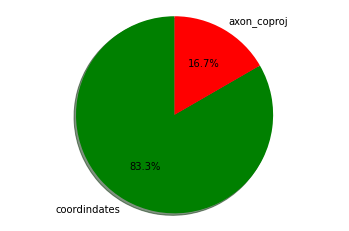

Morphology 147
	 coordindates : 10/50


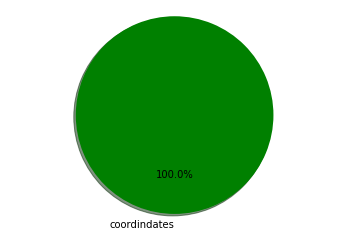

Morphology 15
	 axon_coproj : 30/50


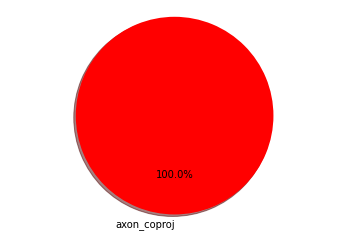

Morphology 172
	 neurite_features : 29/50


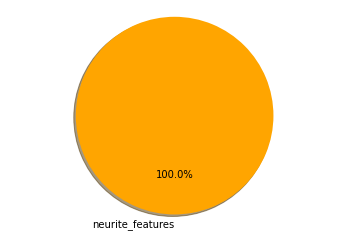

Morphology 61
	 neurite_features : 23/50
	 axon_coproj : 40/50
	 dendrite_coproj : 7/50


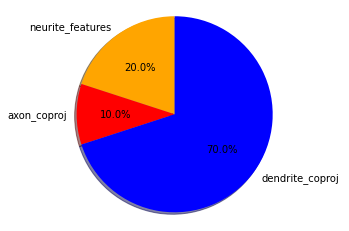

Morphology 74
	 dendrite_coproj : 6/50


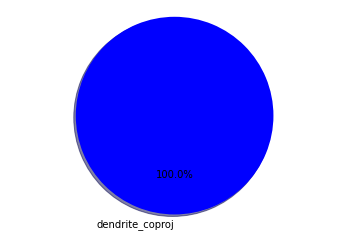

Morphology 139
	 axon_coproj : 26/50


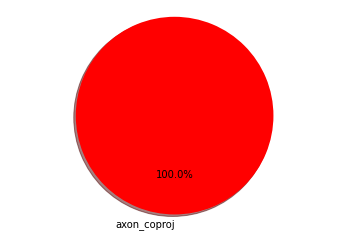

Morphology 5
	 coordindates : 18/50


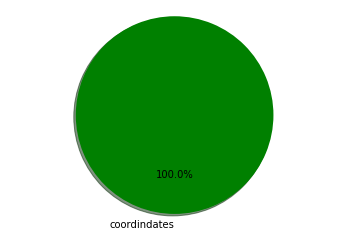

Morphology 19
	 coordindates : 31/50
	 dendrite_coproj : 4/50


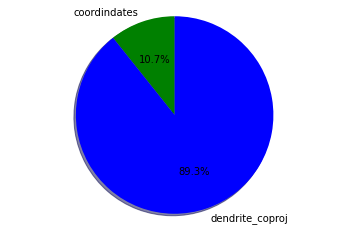

Morphology 163
	 axon_coproj : 23/50
	 dendrite_coproj : 14/50


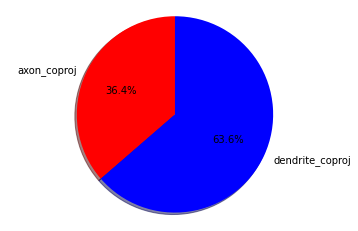

In [153]:
for el in result:
    print("Morphology", el)
    labels = []
    aspect_scores = []
    for index_name, index in INDICES.items():
        scores, points = query_index(index, [query], 50)
        position = np.where(points[0] == el)[0]
        
        if len(position) > 0:
            position = position[0]
            print("\t", index_name, f": {position + 1}/50")
            labels.append(index_name)
            aspect_scores.append(int(100 * (1 / (position + 1))))
    
    
    fig1, ax1 = plt.subplots()
    ax1.pie(aspect_scores, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=[COLORS[el] for el in labels])
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

In [139]:
avg_minus_benchmarks = {
    p: get_average_score(
        {k: v for k, v in INDICES.items() if k != "coordindates"}, p, K, distance=True,
        distance_normalizer=lambda x, index_name: x / means[index_name],
        similarity_normalizer=lambda x, index_name:  scalers[index_name].transform(np.atleast_2d(x))[0][0])
    for p in BENCHMARK_POINTS
}

__Note__ Average can be weighted by user preference specified though some kind of interface

### Compare overlaps with individual indices

(for example, to see if there is one of them that dominates)

In [70]:
def compare_to_individual(benchmark, individual_benchmarks):
    stats = defaultdict(list)
    for index_name, other_benchmark in individual_benchmarks.items():
        for p in benchmark:
            stats[index_name].append(
                len(set(benchmark[p]).intersection(set(other_benchmark[p]))) / len(benchmark[p]))
    for k, v in stats.items():
        print(k, ": {:.2f}+-{:.2f}".format(np.array(v).mean(), np.array(v).std()))

In [71]:
compare_to_individual(concatenated_benchmarks, individual_benchmarks)

coordindates : 0.24+-0.10
neurite_features : 0.65+-0.17
axon_coproj : 0.23+-0.13
dendrite_coproj : 0.16+-0.08


In [72]:
compare_to_individual(concatenated_minus_benchmarks, individual_benchmarks)

coordindates : 0.24+-0.10
neurite_features : 0.65+-0.17
axon_coproj : 0.22+-0.12
dendrite_coproj : 0.16+-0.08


In [73]:
compare_to_individual(avg_benchmarks, individual_benchmarks)

coordindates : 0.55+-0.16
neurite_features : 0.41+-0.10
axon_coproj : 0.45+-0.12
dendrite_coproj : 0.27+-0.12


In [74]:
compare_to_individual(avg_minus_benchmarks, individual_benchmarks)

coordindates : 0.27+-0.12
neurite_features : 0.48+-0.11
axon_coproj : 0.49+-0.11
dendrite_coproj : 0.38+-0.14


In [77]:
compare_to_individual(
    concatenated_benchmarks, {
        "concat-": concatenated_minus_benchmarks,
        "avg": avg_benchmarks,
        "avg-": avg_minus_benchmarks
    })

concat- : 0.99+-0.02
avg : 0.43+-0.15
avg- : 0.45+-0.13


In [78]:
compare_to_individual(
    avg_benchmarks, {
        "avg-": avg_minus_benchmarks
    })

avg- : 0.66+-0.12


## Median ranking

In [1428]:
query = 0
k = 200

In [1429]:
def apply_median_ranking(indices, query):
    for index_name, index in indices.items():
        query_vector = index.reconstruct(query)
        index.search(np.array([query_vector]), k)

In [720]:
a = np.array([4, 0, 1, 3, 2])

In [724]:
ranking = np.argsort(a)

## Fusion graph ranking

In [79]:
def get_position(responses, el, ascending=True):
    sorted_df = pd.DataFrame(
        responses.items(), columns=["id", "score"]).set_index("id").sort_values(
            "score", ascending=ascending)
    return sorted_df.index.get_indexer([el])[0] + 1

In [80]:
def build_fusion_graph(indices, query, k):
    query_responses = {}
    for index_name, index in indices.items():
        query_vector = index.reconstruct(query)
        scores, points = index.search(np.array([query_vector]), k)
        query_responses[index_name] = {
            el: scores[0][i] for i, el in enumerate(points[0])
        }
    
    # Create a node per unique item in response sets
    nodes = {}
    for index_response in query_responses.values():
        for key in index_response.keys():
            if key in nodes:
                nodes[key] += index_response[key]
            else:
                nodes[key] = index_response[key]

    # Compute response sets for each node being a query
    node_responses = {}
    for index_name, index in indices.items():
        node_responses[index_name] = {}
        node_list = list(nodes.keys())
        query_vectors = np.array([index.reconstruct(int(node)) for node in node_list])
        all_scores, all_points = index.search(query_vectors, k)
        node_responses[index_name] = {
            node_list[i]: {el: scores[j] for j, el in enumerate(points)}
            for i, (scores, points) in enumerate(zip(all_scores, all_points))
        }
    
    # Create edges between unique response items
    edges = {}
    for index_name in indices:
        for el in query_responses[index_name]:
            el_responses = [
                response[el] for response in node_responses.values()
            ]
            for response in el_responses:
                for target_el in response:
                    if target_el != el and target_el in nodes:
                        weight = response[target_el] / get_position(
                            query_responses[index_name], el, False)
                        if (el, target_el) not in edges:
                            edges[(el, target_el)] = weight
                        else:
                            edges[(el, target_el)] += weight
                        
    
    fusion_graph = nx.DiGraph()
    fusion_graph.add_nodes_from([
        (node, {"weight": weight})for node, weights  in nodes.items()
    ])
    fusion_graph.add_edges_from([
        (s, t, {"weight": weight}) for (s, t), weights  in edges.items()
    ])
    return fusion_graph

In [82]:
graphs = []
for i in range(data.shape[0]):
    graphs.append(build_fusion_graph(INDICES, 0, 10))

# Elasticsearch experiments

## Create indices

In [ ]:
ELASTIC_URI = "http://localhost:9200"

In [ ]:
morph_mapping = {
    "mappings": {
        "properties": {
            "@id": {
                "type": "keyword"
            },
            "@type": {
                "type": "keyword"
            }
        }
    }
}
for k in KEYWORDS:
    morph_mapping["mappings"]["properties"][k] = {"type": "keyword"}

In [ ]:
emb_mapping = {}
for el in EMBEDDING_VECTORS:
    dim = len(data[el].iloc[0])
    emb_mapping[el] = {
        "mappings": {
            "properties": {
                "@id": {
                    "type": "keyword"
                },
                "@type": {
                    "type": "keyword"
                },
                "embedding": {
                    "dims": dim,
                    "type": "dense_vector"
                },
                "derivation": {
                    "type": "keyword"
                }
            }
        }
    }

Create morphology index

In [ ]:
requests.delete(f"{ELASTIC_URI}/morphologies")
r = requests.put(
    f'{ELASTIC_URI}/morphologies/',
    json=morph_mapping
)

In [ ]:
elastic = Elasticsearch(f'{ELASTIC_URI}/morphologies/')

In [ ]:
actions = [
    {
        "_id": element["@id"],
        "@id": element["@id"],
        "@type": element["@type"],
        "brain_region": element["brain_region"],
        "atlas_release": element["atlas_release"],
        "object_of_study": element["object_of_study"]
        
    }
    for element in morphologies.to_dict("records")
]

try:
    # make the bulk call, and get a response
    response = helpers.bulk(elastic, actions)
    print ("\nRESPONSE:", response)
except Exception as e:
    print("\nERROR:", e)

Create an index per embedding vector

In [ ]:
for el in emb_mapping:
    requests.delete(f"{ELASTIC_URI}/{el}")
    r = requests.put(
        f'{ELASTIC_URI}/{el}/',
        json=emb_mapping[el]
    )

In [ ]:
for embedding in emb_mapping:
    elastic = Elasticsearch(f'{ELASTIC_URI}/{embedding}/')
    
    actions = []
    for element in data[["@id", embedding]].to_dict("records"):
        morph_id = re.findall("https:\/\/(.*)\/(.*)", element["@id"])[0][1]
        actions.append({
            "_id": embedding + "_" + morph_id,
            "@id": embedding + "_" + morph_id,
            "derivation": element["@id"],
            "@type": "Embedding",
            "embedding": element[embedding]
        })

    try:
        # make the bulk call, and get a response
        response = helpers.bulk(elastic, actions)
        print ("\nRESPONSE:", response)

    except Exception as e:
        print("\nERROR:", e)

In [ ]:
r = requests.get(
    f'{ELASTIC_URI}/_cat/indices')
print(r.text)

## Query individual indices

### Search a morphology

In [ ]:
selected_morphology = morphologies["@id"].iloc[0]

In [ ]:
r = requests.post(
    f'{ELASTIC_URI}/morphologies/_search',
    json={
        "query": {
            "term": {
              "@id": {
                "value" : selected_morphology
              }
            }
        }
    }
)
r.json()

### Find its coordinates in the atlas

In [ ]:
r = requests.post(
    f'{ELASTIC_URI}/coordinates/_search',
    json={
        "query": {
            "term": {
              "derivation": {
                "value" : selected_morphology
              }
            }
        }
    }
)
selected_coord_vector = r.json()["hits"]["hits"][0]["_source"]["embedding"]

In [ ]:
selected_coord_vector

### Find 5 closest morphologies "geographically" (Euclidean distance)

In [ ]:
# Euclidean distance
r = requests.post(
    f'{ELASTIC_URI}/coordinates/_search',
    json={
      "size": 5,
      "query": {
        "script_score": {
          "query": {"match_all": {}},
          "script": {
            "source": "1 / (1 + l2norm(params.query_vector, 'embedding'))", 
            "params": {"query_vector": selected_coord_vector}
          }
        }
      }
    }
)
r.json()

### Find its embedding buit using axon co-projection graph

In [ ]:
r = requests.post(
    f'{ELASTIC_URI}/axon_coproj_embedding/_search',
    json={
        "query": {
            "term": {
              "derivation": {
                "value" : selected_morphology
              }
            }
        }
    }
)
selected_embedding_vector = r.json()["hits"]["hits"][0]["_source"]["embedding"]

In [ ]:
selected_embedding_vector

### Find 5 closest morphologies in this space (Cosine similarity)

In [ ]:
# Cosine similarity
r = requests.post(
    f'{ELASTIC_URI}/axon_coproj_embedding/_search',
    json={
      "size": 10,
      "query": {
        "script_score": {
          "query": {"match_all": {}},
          "script": {
            "source": "cosineSimilarity(params.query_vector, 'embedding') + 1.0",
            "params": {"query_vector": selected_embedding_vector}
          }
        }
      }
    }
)
r.json()